## European streamflow database

#### The main objective of this script is to import the previously processed time-series and stations network and organize then in a single dataframe.




Written by: Thiago Victor Medeiros do Nascimento


Link to database spreadsheet: https://docs.google.com/spreadsheets/d/1xS1mWGolKbkn2xthTIW6QNHNkPVV6TnwWXLgYqxAozM/edit#gid=0

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pymannkendall as mk
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import datetime
import tqdm as tqdm
import os
import glob
import calendar
import seaborn as sns

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
%config Completer.use_jedi = False                           # This improve the auto-fill function

import geospatialfunctions as geospatialfunctions            # Geospatialfunctions is a module with useful functions

First we can set our working directory and check it:

In [3]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

#### Data organization:

At this part the concatenation of all the time series is made, and the main objective is to have a final dataframe with all the daily streamflow information together. 



Countries currently available: 


1. Austria (AT)
2. Belgium (BE)
3. Belarus (BY)
4. Bosnia and Herzegovina (BA)
5. Croatia (HR)
6. Cyprus (CY)
7. Czechia (CZ)
8. Denmark (DK)
9. Estonia (EE)
10. Finland (FI)
11. France (FR)
12. Germany (DE)
13. Greece (GR) ***
14. Great Britain (GB)
15. Hungary (HU) ***
16. Iceland (IS)
17. Ireland (IE)
18. Italy (IT)
19. Latvia (LV)
20. Lithuania (LT)
21. Luxembourg (LU)
22. Netherlands (NL)
23. Northern Ireland (UK)
24. Norway (NO)
25. Poland (PL)
26. Portugal (PT)
27. Romania (RO)
28. Russia (RU)
29. Serbia (RS)
30. Slovakia (SK)
31. Slovenia (SI)
32. Spain (ES)
33. Sweden (SE)
34. Switzerland (CH)
_____________________________________
35. North Macedonia (MK)
36. Moldova (MD)
37. Ukraine (UA)
38. Turkey (TR)
39. Bulgaria (BG)


*** Countries requested but not yet available from the official website, however available from GRDC.

#### * Network information lecture per country:

In [4]:
# 1. Austria:
network_AT = pd.read_excel(r"Austria\timeseries\network_ATo.xlsx")

# Here we convert to 4326:
crs={'init':"epsg:3035"}
geometry=[Point(xy) for xy in zip(network_AT.lon, network_AT.lat)]
geodata=gpd.GeoDataFrame(network_AT,crs=crs, geometry=geometry)

network_AT = geodata.to_crs(epsg = 4326)
network_AT['coord_x'] = network_AT.centroid.x  
network_AT['coord_y'] = network_AT.centroid.y

network_AT.drop(["geometry"], axis = 1, inplace = True)

# Here we clean our dataframe for only the useful columns:
network_AT = network_AT[["new_code", "govnr", "name", "river", "area_gov", "elev", "coord_x", "coord_y", "degimpact"]]
network_AT.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "degimpact"]

# Here we assing the country:
network_AT["country"] = "AT"

network_AT = network_AT[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country", "degimpact"]]

# Now we convert the column to str:
network_AT.code = network_AT.code.astype(str)

network_AT

,new_code,code,name,river,area,elev,lon,lat,country,degimpact
0,AT00001,200014,Bangs,Rhein,4647.9,420,9.534835,47.273748,AT,s
1,AT00002,200048,Schruns (Vonbunweg),Litz,102.0,673,9.913677,47.080301,AT,l
2,AT00003,231662,Loruens-Aeule,Ill,535.2,579,9.847765,47.132821,AT,s
3,AT00004,200592,Kloesterle (OEBB),Alfenz,66.6,1014,10.061843,47.128994,AT,s
4,AT00005,200097,Buers (Bruecke L82),Alvier,72.2,564,9.802668,47.150770,AT,s
...,...,...,...,...,...,...,...,...,...,...
594,AT00595,213082,St. Gertraud,Lavant,380.2,512,14.866366,46.885280,AT,l
595,AT00596,213314,St. Jakob,Weissenbach,55.9,460,14.834621,46.841073,AT,l
596,AT00597,213371,Fischering,Lavant,715.6,410,14.836009,46.783894,AT,l
597,AT00598,213819,St. Paul,Granitzbach,61.1,374,14.870838,46.699896,AT,l


In [5]:
# 2. Belgium:
network_BE = pd.read_excel(r"Julia\timeseries\network_BEo.xlsx")
network_BE.code = network_BE.code.astype(str)
network_BE = network_BE[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

network_BE

,new_code,code,name,river,area,elev,lon,lat,country
0,BE00001,10461002,Bierges,Dyle,310.0,NaN,4.606129,50.710583,BE
1,BE00002,19511002,Tubize,Senne,215.0,NaN,4.196446,50.690256,BE
2,BE00003,23711002,Ronquieres,Samme,135.0,NaN,4.224809,50.605923,BE
3,BE00004,29521002,Irchonwelz,DendreOrientale,126.0,NaN,3.751661,50.618903,BE
4,BE00005,29711002,Ath,DendreOrientale,229.0,NaN,3.777834,50.633521,BE
...,...,...,...,...,...,...,...,...,...
163,BE00164,60000000,Erembodegem,Dender,NaN,NaN,4.060017,50.920076,BE
164,BE00165,60000001,Lembeek,Kanaal Brussel Charleroi,NaN,NaN,4.220223,50.708053,BE
165,BE00166,70000000,Haringe,Ijzer,NaN,NaN,2.608001,50.910322,BE
166,BE00167,70000001,Merendree,Afleidingskanaal Leie,NaN,NaN,3.562876,51.089907,BE


In [6]:
# 3. Belarus:
network_BY = pd.read_excel(r"GRDC\timeseries\countries\network_BYo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_BY = network_BY[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_BY.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_BY["country"] = "BY"

# Now we convert the column to str:
network_BY.code = network_BY.code.astype(str)

network_BY

,new_code,code,name,river,area,elev,lon,lat,country
0,BY00001,6258200,NEMERZHA,NAREV,326.0,NaN,24.033333,52.833333,BY
1,BY00002,6258220,MALARYTA,MALARYTA,460.0,NaN,24.093166,51.791840,BY
2,BY00003,6258224,MELENKOVO,KANAL OZHEKHOVSKI,1070.0,NaN,24.694211,52.101812,BY
3,BY00004,6258226,BREST,MUKHAVETS,6590.0,NaN,23.669987,52.084115,BY
4,BY00005,6258230,RADVANICHI MALYYE,RYTA,968.0,NaN,23.995594,52.032501,BY
5,BY00006,6258240,VYSOKAYE,PUL'VA,317.0,NaN,23.374367,52.369312,BY
6,BY00007,6258250,TYUKHINICHI,LYASNAYA,2590.0,NaN,23.676716,52.154292,BY
7,BY00008,6258252,KAMYANYETS,LYASNAYA,1920.0,NaN,23.810000,52.400135,BY
8,BY00009,6258260,CHERSK,KAPAYUWKA,461.0,NaN,23.697541,51.704460,BY
9,BY00010,6273302,VITEBSK,DAUGAVA,27300.0,NaN,30.200000,55.200000,BY


In [7]:
# 4. Bosnia and Herzegovina:
network_BA = pd.read_excel(r"Bosnia\timeseries\network_BAo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_BA = network_BA[["new_code", "New_code_official", "Name", "River", "Area", "Cota", "Lon_wgs84", "Lat_wgs84"]]

# For Belgium we do not have the elevation information:
network_BA.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_BA["country"] = "BA"

# Now we convert the column to str:
network_BA.code = network_BA.code.astype(str)

network_BA

,new_code,code,name,river,area,elev,lon,lat,country
0,BA00001,Martin Brod,Martin Brod,Una,1459.0,310.30,16.134722,44.495556,BA
1,BA00002,Kljuc,Klju?,Sana,754.0,247.09,16.796389,44.525000,BA
2,BA00003,Vrhpolje,Vrhpolje,Sana,NaN,177.64,16.736944,44.689722,BA
3,BA00004,Sanski Most,Sanski Most,Sana,2008.0,156.04,16.666111,44.766389,BA
4,BA00005,Hrustovo,Hrustovo,Sanica,NaN,179.19,16.734167,44.680278,BA
...,...,...,...,...,...,...,...,...,...
86,BA00087,Praca,Pra?a,Pra?a,NaN,684.47,18.764722,43.766944,BA
87,BA00088,Bliha,Bliha,Bliha,NaN,164.95,16.643889,44.771944,BA
88,BA00089,Zepce,Žep?e,Bosna,NaN,224.22,18.020833,44.424167,BA
89,BA00090,Tesanjka,Tešanjka,Usora,NaN,150.70,18.019722,44.678056,BA


In [8]:
# 5. Croatia:
network_HR = pd.read_excel(r"Croatia\timeseries\network_HRo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_HR = network_HR[["new_code", "code", "name", "name", "Area (km2)", "Area (km2)", "Lon", "Lat"]]

# For Belgium we do not have the elevation information:
network_HR.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we adjust some of the columns:
network_HR.elev = np.nan
network_HR.river = network_HR.river.str.split(',\s*').str[1]

# Here we assing the country:
network_HR["country"] = "HR"

# Now we convert the column to str:
network_HR.code = network_HR.code.astype(str)

network_HR

,new_code,code,name,river,area,elev,lon,lat,country
0,HR00001,7136,"ŠIPAK, BAĆINSKA JEZERA",BAĆINSKA JEZERA,NaN,NaN,17.423868,43.069136,HR
1,HR00002,8031,"KOSINJSKI BAKOVAC, BAKOVAC",BAKOVAC,NaN,NaN,15.211571,44.710665,HR
2,HR00003,8056,"ŠPORČIĆ KLANAC, BAKOVAC",BAKOVAC,NaN,NaN,15.233977,44.703883,HR
3,HR00004,5143,"KLJUČ, BEDNJA",BEDNJA,415.67,NaN,16.378201,46.179840,HR
4,HR00005,5140,"LEPOGLAVA, BEDNJA",BEDNJA,89.80,NaN,16.033129,46.206730,HR
...,...,...,...,...,...,...,...,...,...
153,HR00154,3367,"BOŽJAKOVINA, ZELINA",ZELINA,186.00,NaN,16.284426,45.818834,HR
154,HR00155,7253,"ERVENIK, ZRMANJA",ZRMANJA,214.00,NaN,15.939828,44.107690,HR
155,HR00156,5144,"ŽDALA, ŽDALICA",ŽDALICA,NaN,NaN,17.161000,46.155311,HR
156,HR00157,7299,"IZVOR ŽRNOVNICE, ŽRNOVNICA",ŽRNOVNICA,NaN,NaN,16.573901,43.522881,HR


In [9]:
# 6. Cyprus:
network_CY = pd.read_excel(r"GRDC\timeseries\countries\network_CYo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_CY = network_CY[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_CY.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_CY["country"] = "CY"

# Now we convert the column to str:
network_CY.code = network_CY.code.astype(str)

network_CY

,new_code,code,name,river,area,elev,lon,lat,country
0,CY00001,6196020,COAST,CHRYSOCHOU,195.0,5,32.420556,35.042778,CY
1,CY00002,6196040,AKHELIA,POTAMOS TIS EZOUSAS,210.0,27,32.487500,34.741667,CY
2,CY00003,6196060,KOUKLIA,DIARIZOS,260.0,22,32.575000,34.708333,CY
3,CY00004,6196080,KOUKLIA,CHAPOTAMI,110.0,8,32.575000,34.708333,CY
4,CY00005,6196100,LIMNITIS SAW MILL,LIMNITIS,48.7,240,32.720000,35.080000,CY
5,CY00006,6196200,EVRYKHOU,KARGOTIS,63.0,396,32.901389,35.041389,CY
6,CY00007,6196300,VYZAKIA,ELIA,81.0,290,33.016667,35.079167,CY
7,CY00008,6196350,PHINIKARIA,GERMASOGEIA,110.0,100,33.100000,34.754167,CY
8,CY00009,6196400,MALOUNDA,AKAKI,90.0,350,33.183333,35.037500,CY
9,CY00010,6196480,KALAVASOS,VASILIKOS,130.0,43,33.300000,34.766667,CY


In [10]:
# 7. Czechia:
network_CZ = pd.read_excel(r"Julia\timeseries\network_CZo.xlsx")

network_CZ.code = network_CZ.code.astype(str).str.zfill(6)

network_CZ = network_CZ[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

network_CZ

,new_code,code,name,river,area,elev,lon,lat,country
0,CZ00001,001000,Špindlerův Mlýn,Labe,53.06,NaN,15.598108,50.723140,CZ
1,CZ00002,002000,Labská,Labe,61.27,NaN,15.585088,50.710249,CZ
2,CZ00003,003000,Prosečné,Malé Labe,72.75,NaN,15.694443,50.552152,CZ
3,CZ00004,003100,Černý Důl,Čistá,6.53,NaN,15.712667,50.649369,CZ
4,CZ00005,004000,Hostinné,Čistá,77.44,NaN,15.726104,50.541709,CZ
...,...,...,...,...,...,...,...,...,...
533,CZ00534,484000,VD Koryčany,Kyjovka,27.61,NaN,17.189051,49.116826,CZ
534,CZ00535,486000,Kyjov,Kyjovka,117.49,NaN,17.121205,49.010572,CZ
535,CZ00536,486500,Osvětimany,Hruškovice,9.54,NaN,17.246798,49.059223,CZ
536,CZ00537,487000,Popov,Vlára,169.82,NaN,17.970876,49.077326,CZ


In [11]:
# 8. Denmark:
network_DK = pd.read_excel(r"Julia\timeseries\network_DKo.xlsx")
network_DK = network_DK[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

# Now we convert the column to str:
network_DK.code = network_DK.code.astype(str)

network_DK

,new_code,code,name,river,area,elev,lon,lat,country
0,DK00001,e3db7850-9c76-498d-bfd7-7da5d35ba32a,Gudenå,Gudenå,NaN,NaN,9.670460,56.240264,DK
1,DK00002,fddb45ef-0680-4d20-beab-c74715d9ba5f,"Arreskov Sø, Tilløb 4","Arreskov Sø, Tilløb 4",NaN,NaN,10.290896,55.147061,DK
2,DK00003,fde3d0da-1ead-4eb9-9009-cfe286a95b25,"Søbo Sø, Tilløb 3","Søbo Sø, Tilløb 3",NaN,NaN,10.204787,55.203975,DK
3,DK00004,fe3cf6a6-88de-42cc-b6d5-e7eaa2b9ea19,Hove Å,Hove Å,NaN,NaN,12.136257,55.727224,DK
4,DK00005,fe20e861-1efd-4df2-aec0-cfbcd7494b59,Holtum Å,Holtum Å,NaN,NaN,9.056961,55.984249,DK
...,...,...,...,...,...,...,...,...,...
902,DK00903,fce7a3e3-71f8-4df5-9e54-e2e490c2ae35,Nimdrup Bæk,Nimdrup Bæk,NaN,NaN,9.542638,56.009080,DK
903,DK00904,fce63ce5-df58-49e7-9f46-26ac2456e3b1,Døde Å,Døde Å,NaN,NaN,10.137365,56.129407,DK
904,DK00905,fd179f17-d204-4539-ba69-4539e28b89c7,"Gråsten Slotssø, Afløb","Gråsten Slotssø, Afløb",NaN,NaN,9.596856,54.923907,DK
905,DK00906,fdc6dd5a-dde7-41cd-b8e4-cdc5745831b4,"Hvidkilde Sø, Afløb 1","Hvidkilde Sø, Afløb 1",NaN,NaN,10.531329,55.072971,DK


In [12]:
# 9. Estonia:
network_EE = pd.read_excel(r"GRDC\timeseries\countries\network_EEo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_EE = network_EE[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_EE.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_EE["country"] = "EE"

# Now we convert the column to str:
network_EE.code = network_EE.code.astype(str)

network_EE

,new_code,code,name,river,area,elev,lon,lat,country
0,EE00001,6172005,VARANGU,PREEDI JOGI,90.0,34.80,26.110833,59.035000,EE
1,EE00002,6172010,PAJUPEA,LEIVAJOGI,84.0,33.60,24.968889,59.380833,EE
2,EE00003,6172011,KEHRA,JAGALA,903.0,40.12,25.340278,59.344167,EE
3,EE00004,6172012,KLOOSTRIMETSA,PIRITA JOGI,794.0,5.98,24.879167,59.466111,EE
4,EE00005,6172013,KEILA,KEILA JOGI,635.0,23.77,24.434722,59.308611,EE
5,EE00006,6172014,PUDISOO,PUDISOO JOGI,123.0,8.62,25.594444,59.508611,EE
6,EE00007,6172015,VARANGU,SELJA JOGI,390.0,53.35,26.351667,59.472222,EE
7,EE00008,6172016,LUGANUSE,PURTSE JOGI,784.0,32.02,27.039167,59.383889,EE
8,EE00009,6172020,POHJAKA I,ESNA JOGI,215.0,63.53,25.669444,58.891944,EE
9,EE00010,6172021,VALGU,VELISE JOGI,131.0,33.43,24.645006,58.817886,EE


In [13]:
# 10. Finland:
network_FI = pd.read_excel(r"Julia\timeseries\network_FIo.xlsx")

# Here we set the number of algorithms for the code column:
network_FI.code = network_FI.code.astype(str).str.zfill(7)

network_FI = network_FI[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country", "lake"]]

# Now we convert the column to str:
network_FI.code = network_FI.code.astype(str)

network_FI

,new_code,code,name,river,area,elev,lon,lat,country,lake
0,FI00001,5902650,"Nuasjärvi, Koivukoski",Oulujoki,7475.0,NaN,27.736529,64.226285,FI,11.7
1,FI00002,5902700,Nuasjärvi - luusua,Oulujoki,7475.0,NaN,27.736529,64.226285,FI,11.7
2,FI00003,6000110,Iso Puutiojärvi - luusua,Kiiminginjoki,371.0,NaN,27.595146,64.865324,FI,4.6
3,FI00004,6100614,Näljänkäjärvi - luusua,Iijoki,280.0,NaN,28.340834,65.037027,FI,3.7
4,FI00005,6100620,Suolijärvi - luusua,Iijoki,1313.0,NaN,28.069000,65.144550,FI,3.9
...,...,...,...,...,...,...,...,...,...,...
664,FI00665,6502150,Pirttikoski,Kemijoki,27703.0,NaN,27.155087,66.340055,FI,5.2
665,FI00666,6502151,"Juotas, konevirtaama",Kemijoki,400.0,NaN,26.950329,66.321034,FI,7.7
666,FI00667,6502200,Koskenkylä,Kemijoki,33370.0,NaN,26.155849,66.410076,FI,3.0
667,FI00668,6502250,Vanttauskoski,Kemijoki,29021.0,NaN,26.685973,66.367788,FI,5.2


In [14]:
# 11. France:
network_FR = pd.read_excel(r"France\timeseries\network_FRo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_FR = network_FR[["new_code", "Code", "CodeOld", "Code", "area", "level", "xcoord", "ycoord"]]

network_FR.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we adjust some of the columns:
network_FR.river = np.nan

# Here we assing the country:
network_FR["country"] = "FR"

# Now we convert the column to str:
network_FR.code = network_FR.code.astype(str)

network_FR

,new_code,code,name,river,area,elev,lon,lat,country
0,FR00001,A021005050,A0210050,NaN,35878.0,246.0,7.606153,47.556970,FR
1,FR00002,A022020001,A0220200,NaN,15.0,277.0,7.528982,47.564377,FR
2,FR00003,A022065001,A0220650,NaN,8.2,274.0,7.508168,47.587489,FR
3,FR00004,A023010001,A0220570,NaN,NaN,248.0,7.545294,47.603575,FR
4,FR00005,A023020001,A0230201,NaN,NaN,247.0,7.556488,47.596980,FR
...,...,...,...,...,...,...,...,...,...
3153,FR03154,Y980000301,Y9806210,NaN,53.0,34.0,9.237134,41.596813,FR
3154,FR03155,Y980000302,Y9800003,NaN,53.0,34.0,9.237163,41.596406,FR
3155,FR03156,Y982000101,Y9825010,NaN,29.0,4.0,9.204303,41.444451,FR
3156,FR03157,Y991000101,Y9905010,NaN,17.0,30.0,9.146374,41.464203,FR


In [15]:
# 12. Germany:
network_DE = pd.read_excel(r"GRDC\timeseries\countries\network_DEo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_DE = network_DE[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_DE.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_DE["country"] = "DE"

# Now we convert the column to str:
network_DE.code = network_DE.code.astype(str)

network_DE

,new_code,code,name,river,area,elev,lon,lat,country
0,DE00001,6321100,GOCH,NIERS,1203.0,12.02,6.151000,51.684000,DE
1,DE00002,6321200,STAH,ROER,2105.0,32.45,6.104184,51.097604,DE
2,DE00003,6334270,SOHOLM,SOHOLMER AU,352.0,1.70,9.022802,54.699745,DE
3,DE00004,6334280,LECK-KARLSMARK,LECKER AU,134.0,2.31,8.976074,54.770658,DE
4,DE00005,6334800,TREIA,TREENE,481.0,5.00,9.317255,54.514342,DE
...,...,...,...,...,...,...,...,...,...
331,DE00332,6357503,HARTAU,LUSATIAN NEISSE RIVER,376.0,233.14,14.821047,50.872211,DE
332,DE00333,6357505,HARTAU 1,LUSATIAN NEISSE RIVER,370.0,236.54,14.821300,50.859375,DE
333,DE00334,6357510,TAUCHRITZ,PLIESSNITZ,162.0,197.20,14.944133,51.064069,DE
334,DE00335,6357520,ZITTAU 5,MANDAU,NaN,NaN,14.802623,50.891976,DE


In [16]:
# 13. Greece ***:
network_GR = pd.read_excel(r"GRDC\timeseries\countries\network_GRo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_GR = network_GR[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_GR.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_GR["country"] = "GR"

# Now we convert the column to str:
network_GR.code = network_GR.code.astype(str)

network_GR

,new_code,code,name,river,area,elev,lon,lat,country
0,GR00001,6261100,TSIMOVO,ARACHTHOS POTAMOS,640,350,20.980,39.5800,GR
1,GR00002,6261200,AVLAKION,ACHELOOS POTAMOS,1349,304,21.385,39.1575,GR


In [17]:
# 14. Great Britain:
network_GB = pd.read_excel(r"GB\timeseries\network_GBo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_GB = network_GB[["new_code", "gauge_id", "gauge_name", "gauge_name", "area", "gauge_elev", "gauge_lon", "gauge_lat", "num_reservoir"]]

network_GB.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "num_reservoir"]

# Here we assing the country:
network_GB["country"] = "GB"

network_GB = network_GB[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country", "num_reservoir"]]

# Now we convert the column to str:
network_GB.code = network_GB.code.astype(str)

network_GB

,new_code,code,name,river,area,elev,lon,lat,country,num_reservoir
0,GB00001,10002,Ugie at Inverugie,Ugie at Inverugie,325.72,8.5,-1.83,57.53,GB,0
1,GB00002,10003,Ythan at Ellon,Ythan at Ellon,532.29,3.8,-2.09,57.36,GB,0
2,GB00003,1001,Wick at Tarroul,Wick at Tarroul,158.18,13.0,-3.27,58.48,GB,1
3,GB00004,101002,Medina at Shide,Medina at Shide,30.61,10.4,-1.29,50.69,GB,0
4,GB00005,101005,Eastern Yar at Budbridge,Eastern Yar at Budbridge,24.31,17.2,-1.25,50.65,GB,0
...,...,...,...,...,...,...,...,...,...,...
666,GB00667,95001,Inver at Little Assynt,Inver at Little Assynt,138.47,60.3,-5.15,58.17,GB,0
667,GB00668,96001,Halladale at Halladale,Halladale at Halladale,193.72,23.2,-3.90,58.48,GB,0
668,GB00669,96002,Naver at Apigill,Naver at Apigill,474.01,5.1,-4.21,58.48,GB,0
669,GB00670,96004,Strathmore at Allnabad,Strathmore at Allnabad,105.36,21.9,-4.64,58.35,GB,0


In [18]:
# 15. Hungary ***:
network_HU = pd.read_excel(r"GRDC\timeseries\countries\network_HUo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_HU = network_HU[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_HU.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_HU["country"] = "HU"

# Now we convert the column to str:
network_HU.code = network_HU.code.astype(str)

network_HU

,new_code,code,name,river,area,elev,lon,lat,country
0,HU00001,6442050,SZENTGOTTHARD,RAAB,3084,216.0,16.330000,46.952915,HU
1,HU00002,6442100,ZALAAPATI,ZALA,1528,106.0,17.116667,46.733334,HU
2,HU00003,6442200,RABASZENTMIKLOS,MARCAL,2710,113.0,17.416666,47.530000,HU
3,HU00004,6442300,KURD,KAPOS,2119,104.0,18.316668,46.450000,HU
4,HU00005,6442450,DUNAALMAS,DANUBE RIVER,171720,103.0,18.330000,47.730000,HU
5,HU00006,6442500,NAGYMAROS,DANUBE RIVER,183533,100.0,18.950000,47.780000,HU
6,HU00007,6442600,MOHACS,DANUBE RIVER,209064,80.0,18.670000,46.000000,HU
7,HU00008,6444090,TISZABECS,TISA,9707,115.0,22.816668,48.099998,HU
8,HU00009,6444100,SZEGED,TISA,138408,74.0,20.166666,46.250000,HU
9,HU00010,6444110,MAKO,MAROS,30149,80.0,20.483334,46.216667,HU


In [19]:
# 16. Iceland:
network_IS = pd.read_excel(r"GRDC\timeseries\countries\network_ISo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_IS = network_IS[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_IS.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_IS["country"] = "IS"

# Now we convert the column to str:
network_IS.code = network_IS.code.astype(str)

network_IS

,new_code,code,name,river,area,elev,lon,lat,country
0,IS00001,6401070,STEKKUR,NORDHURA,507,18,-21.60337,64.71072,IS
1,IS00002,6401080,KLJAFOSS,HVITA,1574,18,-21.41046,64.69229,IS
2,IS00003,6401090,SELFOSS,OLFUSA,5662,12,-21.00666,63.93796,IS
3,IS00004,6401110,EFSTADALSBRU,BRUARA,219,150,-20.51970,64.26440,IS
4,IS00005,6401111,DYNJANDI,BRUARA,640,57,-20.55913,64.16010,IS
5,IS00006,6401120,KROKUR,THJORSA,7314,60,-20.63135,63.93362,IS
6,IS00007,6401130,HOLL,JOKULSA I FLJOTSDAL,558,50,-15.08830,64.98390,IS
7,IS00008,6401140,TUNGUFOSS,EYSTRI-RANGA,419,59,-20.11284,63.79723,IS
8,IS00009,6401150,ARBAEJARFOSS,YTRI-RANGA,621,35,-20.34065,63.86324,IS
9,IS00010,6401160,EYJOLFSSTADIR,FOSSA,115,40,-14.48605,64.75281,IS


In [20]:
# 17. Ireland:
network_IE = pd.read_excel(r"Ireland\timeseries\network_IEo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_IE = network_IE[["new_code", "Code", "Name", "River", "Area", "Area", "Lon", "Lat"]]

network_IE.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]
network_IE.elev = np.nan

network_IE.code = network_IE.code .astype(str).str.zfill(5)

# Here we assing the country:
network_IE["country"] = "IE"

# Now we convert the column to str:
network_IE.code = network_IE.code.astype(str)

network_IE

,new_code,code,name,river,area,elev,lon,lat,country
0,IEOPW001,01041,Sandy Mills,DEELE,113.00,NaN,-7.575758,54.838318,IE
1,IEOPW002,01043,Ballybofey,FINN [Donegal],319.00,NaN,-7.790749,54.799769,IE
2,IEOPW003,03055,Glaslough,MOUNTAIN WATER,72.00,NaN,-6.894344,54.323281,IE
3,IEOPW004,03058,Cappoge Bridge,BLACKWATER [MONAGHAN],65.00,NaN,-7.021297,54.266809,IE
4,IEOPW005,06011,Moyles Mill,FANE,230.00,NaN,-6.596077,54.011574,IE
...,...,...,...,...,...,...,...,...,...
459,IEEPA460,26221,SUMMER HILL,CROSS,103.30,NaN,-7.985038,53.412141,IE
460,IEEPA461,09040,NICHOLASTOWN,KILCULLEN STREAM,38.17,NaN,-6.736682,53.127977,IE
461,IEEPA462,07109,KISHAWANNY WEIR,BOYNE,57.40,NaN,-7.030746,53.347393,IE
462,IEEPA463,26220,SHRULE BR.,INNY,1108.26,NaN,-7.797099,53.552842,IE


In [21]:
# 18. Italy:
network_IT = pd.read_excel(r"IT\timeseries\network_ITo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_IT = network_IT[["new_code", "Code", "Name", "region", "Area", "Elev", "xcoord", "ycoord"]]

network_IT.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we adjust some of the columns:

# Here we assing the country:
network_IT["country"] = "IT"

# Now we convert the column to str:
network_IT.code = network_IT.code.astype(str)

network_IT

,new_code,code,name,river,area,elev,lon,lat,country
0,ITEMI001,Cardinala Idice,IDICE,emilia,NaN,15.0,11.801844,44.578911,IT
1,ITEMI002,Castenaso,IDICE,emilia,NaN,38.0,11.470171,44.507477,IT
2,ITEMI003,Cadelbosco,CROSTOLO,emilia,NaN,38.0,10.581190,44.778796,IT
3,ITEMI004,Polesella,PO,emilia,NaN,9.0,11.756259,44.959259,IT
4,ITEMI005,Berceto Baganza,PARMA,emilia,NaN,803.0,9.993069,44.503582,IT
...,...,...,...,...,...,...,...,...,...
400,ITTOS401,TOS10005700,Casamallecchi,toscana,NaN,NaN,11.000000,43.000000,IT
401,ITTOS402,TOS10005710,Ornate,toscana,NaN,NaN,11.000000,43.000000,IT
402,ITTOS403,TOS10005720,Ponte di Torniella,toscana,NaN,NaN,11.154131,43.073982,IT
403,ITTOS404,TOS10005760,Monte Amiata Scalo,toscana,NaN,160.0,11.392822,43.069893,IT


In [22]:
# 19. Latvia:
network_LV = pd.read_excel(r"GRDC\timeseries\countries\network_LVo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_LV = network_LV[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_LV.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_LV["country"] = "LV"

# Now we convert the column to str:
network_LV.code = network_LV.code.astype(str)

network_LV

,new_code,code,name,river,area,elev,lon,lat,country
0,LV00001,6372100,VALMIERA,KOIVA JOGI,6280.0,NaN,25.423400,57.536200,LV
1,LV00002,6372103,TILDERI,KOIVA JOGI,2230.0,62.07,26.350000,57.450000,LV
2,LV00003,6372104,SIGULDA,KOIVA JOGI,8510.0,11.40,24.841719,57.165364,LV
3,LV00004,6372111,OLI,TULIJA,40.0,169.67,25.910000,57.150000,LV
4,LV00005,6372941,TERANDA,UZAVA,440.0,5.69,21.582278,57.093239,LV
...,...,...,...,...,...,...,...,...,...
56,LV00057,6373922,ROJUPE,ROJA,398.0,7.97,22.724103,57.490444,LV
57,LV00058,6373931,MAZSALACA,SALACA,2260.0,37.75,25.052450,57.857356,LV
58,LV00059,6373932,LAGASTE,SALACA,3220.0,17.03,24.490319,57.846675,LV
59,LV00060,6373933,VILNISI,RUJA,636.0,41.66,25.292322,57.905267,LV


In [23]:
# 20. Lithuania:
network_LT = pd.read_excel(r"GRDC\timeseries\countries\network_LTo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_LT = network_LT[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_LT.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_LT["country"] = "LT"

# Now we convert the column to str:
network_LT.code = network_LT.code.astype(str)

network_LT

,new_code,code,name,river,area,elev,lon,lat,country
0,LT00001,6573014,PAPILE,VENTA,1560.0,67.99,22.783333,56.150000,LT
1,LT00002,6573015,LECKAVA,VENTA,4020.0,39.61,22.233600,56.394600,LT
2,LT00003,6573016,RAMUCIAI,VENTA,708.0,95.50,22.866667,55.833333,LT
3,LT00004,6573020,MIKUZIAI,VEIVIRZAS,336.0,10.71,21.522700,55.560300,LT
4,LT00005,6573030,AUNUVENAI,AUNUVA,93.8,100.15,22.766667,55.850000,LT
...,...,...,...,...,...,...,...,...,...
71,LT00072,6574723,VOKE-ZAGARINE,MERKYS,435.0,130.40,25.109400,54.448400,LT
72,LT00073,6574725,ZAGARINE,MERKYS,429.0,130.69,25.103600,54.448200,LT
73,LT00074,6574727,ZERVYNOS,ULA,679.0,103.92,24.500000,54.116667,LT
74,LT00075,6574811,ZINDAICIAI,MITUVA,402.0,25.06,22.692300,55.173600,LT


In [24]:
# 21. Luxembourg:
network_LU = pd.read_excel(r"Julia\timeseries\network_LUo.xlsx")

network_LU = network_LU[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

# Now we convert the column to str:
network_LU.code = network_LU.code.astype(str)

network_LU

,new_code,code,name,river,area,elev,lon,lat,country
0,LU00001,17,Bigonville,Sure,308.40,NaN,5.801399,49.869821,LU
1,LU00002,10,Bissen,Attert,291.50,NaN,6.056414,49.784853,LU
2,LU00003,15,Bollendorf,Sure,3227.00,NaN,6.359193,49.850919,LU
3,LU00004,35,Clervaux,Clerve,147.20,NaN,6.027574,50.054520,LU
4,LU00005,13,Dasbourg,Our,450.40,NaN,6.126077,50.049832,LU
5,LU00006,11,Diekirch,Sure,2149.00,NaN,6.161813,49.866622,LU
6,LU00007,42,EttelbrueckAlzette,Alzette,1091.90,NaN,6.098584,49.844800,LU
7,LU00008,19,Heiderscheidergrund,Sure,429.00,NaN,5.950724,49.901196,LU
8,LU00009,2,Hesperange,Alzette,292.30,NaN,6.149080,49.586287,LU
9,LU00010,6,Hunnebuer,Eisch,164.20,NaN,6.079524,49.729184,LU


In [25]:
# 22. Netherlands:
# Data from Julia:
network_NL = pd.read_excel(r"Julia\timeseries\network_NLo.xlsx")

network_NL = network_NL[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

# Now we convert the column to str:
network_NL.code = network_NL.code.astype(str)

network_NL

,new_code,code,name,river,area,elev,lon,lat,country
0,NL00001,24,Stah,Roer,2152.00,NaN,6.104481,51.097734,NL
1,NL00002,312,Vlootbekermolen,Vlootbeek,76.67,NaN,5.924372,51.149860,NL
2,NL00003,1132,Eys,Eyserbeek,27.11,NaN,5.929363,50.825340,NL
3,NL00004,1231,Partij,Selzerbeek,28.74,NaN,5.921758,50.810588,NL
4,NL00005,1334,Azijnfabriek,Gulp,46.05,NaN,5.891548,50.814140,NL
5,NL00006,1541,Mesch,Voer,56.95,NaN,5.736490,50.764106,NL
6,NL00007,1642,Nekum,Jeker,462.09,NaN,5.672606,50.827608,NL
7,NL00008,6421102,Venlo,Meuse,26040.00,NaN,6.160176,51.368806,NL
8,NL00009,6421500,Borgharen,Meuse,21301.00,NaN,5.693836,50.871400,NL
9,NL00010,6435060,Lobith,Rhine,160800.00,NaN,6.110000,51.849000,NL


In [26]:
# Data from GRDC:
network_NL_grdc = pd.read_excel(r"GRDC\timeseries\countries\network_NL_grdc_o.xlsx")

# Here we clean our dataframe for only the useful columns:
network_NL_grdc = network_NL_grdc[["Unnamed: 0", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_NL_grdc.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_NL_grdc["country"] = "NL"

# Now we convert the column to str:
network_NL_grdc.code = network_NL_grdc.code.astype(str)

network_NL_grdc

,new_code,code,name,river,area,elev,lon,lat,country
0,NLGRDC11,6421100,LITH,MEUSE,29000,5,5.45,51.82,NL
1,NLGRDC12,6421101,SINT PIETER NOORD,MEUSE,21300,44,5.71,50.83,NL
2,NLGRDC13,6421500,BORGHAREN,MEUSE,21301,40,5.72,50.87,NL


In [27]:
# 23. Northern Ireland:
network_NI = pd.read_excel(r"NorthernIreland\timeseries\network_NIo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_NI = network_NI[["new_code", "code", "name", "river", "catchment-", "station-le", "longitude", "latitude"]]

network_NI.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_NI["country"] = "NI"

# Now we convert the column to str:
network_NI.code = network_NI.code.astype(str)

network_NI

,new_code,code,name,river,area,elev,lon,lat,country
0,NI00001,201005,Camowen at Camowen Terrace,Camowen,276.6,66.0,-7.28785,54.60357,NI
1,NI00002,203011,Main at Dromona,Main,243.5,71.0,-6.36523,54.91773,NI
2,NI00003,203012,Ballinderry at Ballinderry Bridge,Ballinderry,430.2,16.0,-6.56471,54.65813,NI
3,NI00004,203017,Upper Bann at Dynes Bridge,Upper Bann,316.3,13.0,-6.39486,54.39783,NI
4,NI00005,203018,Six-Mile Water at Antrim,Six-Mile Water,277.6,13.0,-6.22363,54.71503,NI
5,NI00006,203019,Claudy at Glenone Bridge,Claudy,126.3,14.0,-6.50079,54.87266,NI
6,NI00007,203020,Moyola at Moyola New Bridge,Moyola,304.3,13.0,-6.51548,54.75354,NI
7,NI00008,203021,Kellswater at Curry's Bridge,Kellswater,126.3,35.0,-6.28160,54.80962,NI
8,NI00009,203022,Blackwater at Derrymeen Bridge,Blackwater,182.9,50.1,-7.03778,54.42201,NI
9,NI00010,203024,Cusher at Gamble's Bridge,Cusher,170.7,14.0,-6.38868,54.36172,NI


In [28]:
# 24. Norway:
network_NO = pd.read_excel(r"Julia\timeseries\network_NOo.xlsx")
network_NO = network_NO[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

# Here we convert the code column to str:
network_NO.code = network_NO.code.astype(str)
network_NO

,new_code,code,name,river,area,elev,lon,lat,country
0,NO00001,29.19.0,Høylandsåna,Storåna,16.38,NaN,5.740205,58.832218,NO
1,NO00002,29.11.0,Sandvedparken,Storåna,24.50,NaN,5.730242,58.842287,NO
2,NO00003,29.10.0,Stokkelandsvatnet,Storåna,19.34,NaN,5.717747,58.821528,NO
3,NO00004,28.7.0,Haugland,Hååna,139.35,NaN,5.647563,58.692906,NO
4,NO00005,27.52.0,Byrkjelandsvatnet utløp,Bjerkreimvassdraget,177.47,NaN,6.198604,58.697443,NO
...,...,...,...,...,...,...,...,...,...
184,NO00185,33.4.0,Kalltveit i Årdal,Årdalselva,307.38,NaN,6.283894,59.134914,NO
185,NO00186,307.7.0,Landbru,Linvasselva/Faxälven,61.37,NaN,13.916363,64.886736,NO
186,NO00187,303.2.0,Kobvatn,Siddisjaurevassdraget/Vietasätno/Luleälven,82.70,NaN,17.106267,68.146980,NO
187,NO00188,30.8.0,Øvstabøstøl,Dirdalsåna,49.85,NaN,6.573901,58.867643,NO


In [29]:
# 25. Poland:
network_PL = pd.read_excel(r"GRDC\timeseries\countries\network_PLo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_PL = network_PL[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_PL.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_PL["country"] = "PL"

# Now we convert the column to str:
network_PL.code = network_PL.code.astype(str)

network_PL

,new_code,code,name,river,area,elev,lon,lat,country
0,PL00001,6456105,LOBEZ,REGA,615.5,54.074,15.613333,53.628889,PL
1,PL00002,6456107,TRZEBIATOW,REGA,2637.6,-0.169,15.260833,54.063333,PL
2,PL00003,6456110,LUPAWA,LUPAWA,437.0,66.990,17.415556,54.419444,PL
3,PL00004,6456120,SLUPSK,SLUPIA,1451.6,12.683,17.031389,54.470000,PL
4,PL00005,6457010,GOZDOWICE,ODER RIVER,109810.7,2.980,14.317778,52.764167,PL
...,...,...,...,...,...,...,...,...,...
98,PL00099,6458920,ROZKOSZ,MUCHAWKA,292.9,141.510,22.237500,52.151389,PL
99,PL00100,6458924,LOCHOW,LIWIEC,2471.4,94.910,21.678333,52.510000,PL
100,PL00101,6458940,CIEKSYN,WKRA,4900.6,76.589,20.631944,52.576389,PL
101,PL00102,6458950,TRYNCZA,WISLOK,3523.6,165.085,22.547222,50.162222,PL


In [30]:
# 26. Portugal:
network_PT = pd.read_excel(r"Portugal\timeseries\network_PTo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_PT = network_PT[["new_code", "ID", "Name", "River", "Area_km2", "Elev", "Lon", "Lat"]]

network_PT.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_PT["country"] = "PT"

# Here we set the RE:
import re
network_PT["RE"] = network_PT["name"].str.extract(r'\((.*?)\)\s*$')

network_PT = network_PT[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country", "RE"]]

# Here we adjust it:
network_PT.iloc[13, -1] = np.nan
network_PT.iloc[24, -1] = np.nan
network_PT.iloc[64, -1] = np.nan
network_PT.iloc[79, -1] = np.nan
network_PT.iloc[84, -1] = np.nan
network_PT.iloc[110, -1] = np.nan
network_PT.iloc[111, -1] = np.nan
network_PT.iloc[166, -1] = np.nan
network_PT.iloc[189, -1] = np.nan
network_PT.iloc[192, -1] = np.nan
network_PT.iloc[214, -1] = np.nan
network_PT.iloc[215, -1] = np.nan
network_PT.iloc[254, -1] = np.nan
network_PT.iloc[256, -1] = np.nan
network_PT.iloc[279, -1] = np.nan

# Now we convert the column to str:
network_PT.code = network_PT.code.astype(str)


network_PT

,new_code,code,name,river,area,elev,lon,lat,country,RE
0,PT00001,03J/02H,ABELHEIRA CANAL (R.E.),RIBEIRO DAS CAVADAS OU DE ABELHEIRA,2.6,756,-7.969000,41.795000,PT,R.E.
1,PT00002,15G/02H,AGROAL,RIO NABÃO,608.49,88,-8.437000,39.679000,PT,NaN
2,PT00003,11H/02H,AGUIEIRA (R.E.),RIO MONDEGO,3072.41,89,-8.208000,40.341000,PT,R.E.
3,PT00004,26J/01H,ALBERNOA,RIO COBRES OU RIBEIRA DE TERGES,169.84,131,-7.965000,37.853000,PT,NaN
4,PT00005,11H/01H,ALMAÇA,RIBEIRA DE MORTAGUA OU DE CRISTINA OU DA FOZ O...,204.08,72,-8.228000,40.340000,PT,NaN
...,...,...,...,...,...,...,...,...,...,...
275,PT00276,08L/02H,VILAR,RIO TÁVORA,358.35,511,-7.534000,40.989000,PT,NaN
276,PT00277,03P/01H,VINHAIS QUINTA RANCA (R.E.),RIO TUELA,478.54,441,-6.995000,41.810000,PT,R.E.
277,PT00278,31K/06HA,VÁRZEAS,BARRANCO DO MONTE DOS LAGARTOS,-,-,-7.796518,37.153177,PT,NaN
278,PT00279,17C/03H,ÓBIDOS,RIO ARNOIA,106.65,12,-9.152000,39.361000,PT,NaN


In [31]:
# 27. Romania:
network_RO = pd.read_excel(r"GRDC\timeseries\countries\network_ROo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_RO = network_RO[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_RO.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_RO["country"] = "RO"

# Now we convert the column to str:
network_RO.code = network_RO.code.astype(str)

network_RO

,new_code,code,name,river,area,elev,lon,lat,country
0,RO00001,6742200,ORSOVA (1971:DROBATA-TURNU SEVERIN),DANUBE RIVER,576232,44.00,22.420000,44.700000,RO
1,RO00002,6742201,BAZIAS,DANUBE RIVER,570896,64.00,21.379444,44.814722,RO
2,RO00003,6742400,SAG,TAMIS,4493,477.00,21.176944,45.645833,RO
3,RO00004,6742451,CORNET,OLT,13733,312.23,24.299444,45.385000,RO
4,RO00005,6742452,HOGHIZ,OLT,7225,797.00,25.300556,45.991667,RO
5,RO00006,6742500,ZIMNICEA,DANUBE RIVER,658400,16.00,25.354444,43.627222,RO
6,RO00007,6742552,PODARI,JIU,9334,446.00,23.789444,44.255555,RO
7,RO00008,6742600,RADAUTI,PRUT,9074,101.87,26.812222,48.240833,RO
8,RO00009,6742700,LUNGOCI,SIRET,36030,12.20,27.512222,45.555861,RO
9,RO00010,6742701,DRAGESTI,SIRET,11899,160.52,26.946111,46.725833,RO


In [32]:
# 28. Russia:
network_RU = pd.read_excel(r"GRDC\timeseries\countries\network_RUo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_RU = network_RU[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_RU.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_RU["country"] = "RU"

# Now we convert the column to str:
network_RU.code = network_RU.code.astype(str)


network_RU

,new_code,code,name,river,area,elev,lon,lat,country
0,RU00001,6955430,NOVOSARATOVKA,NEVA,281000.0,NaN,30.529444,59.837222,RU
1,RU00002,6955450,PODSOSONYE,PEREKHODA,138.0,63.0,31.066667,57.633333,RU
2,RU00003,6955500,DOMACHEVO,DYMKA,112.0,NaN,33.816667,59.566667,RU
3,RU00004,6955600,OLONETS,OLONKA,2120.0,4.0,32.968333,60.980000,RU
4,RU00005,6955610,XII GES,SVIR',67100.0,NaN,34.300000,60.930000,RU
...,...,...,...,...,...,...,...,...,...
93,RU00094,6984700,GUERGUEBIL,KAZIKUMUKHSKOYE KOYSU,1850.0,655.0,46.960556,42.386667,RU
94,RU00095,6984800,LUCHEK,KARA-SAMUR,481.0,1436.0,47.307222,41.611667,RU
95,RU00096,6987050,TAT'YANOVKA,PSEZUAPSE,255.0,NaN,39.409167,43.959167,RU
96,RU00097,6987100,SOLOKHAUL,SHAKHE,423.0,133.0,39.678056,43.799444,RU


In [33]:
# 29. Serbia:
network_RS = pd.read_excel(r"Serbia\timeseries\network_RSo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_RS = network_RS[["new_code", "Code", "Name", "River", "Area", "Elev", "Lon", "Lat"]]

network_RS.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_RS["country"] = "RS"

# Now we convert the column to str:
network_RS.code = network_RS.code.astype(str)

network_RS

,new_code,code,name,river,area,elev,lon,lat,country
0,RS00001,42010,BEZDAN,DUNAV,210250,81,18.85660,45.85461,RS
1,RS00002,42020,BOGOJEVO,DUNAV,251593,77,19.08000,45.53000,RS
2,RS00003,44020,SENTA,TISA,141715,74,20.09309,45.93459,RS
3,RS00004,45090,SREMSKA MITROVICA,SAVA,87996,72,19.60125,44.96592,RS
4,RS00005,45837,PRIJEPOLJE,LIM,3160,443,19.63978,43.38364,RS
5,RS00006,47090,LJUBICEVSKI MOST,VELIKA MORAVA,37320,73,21.13149,44.58505,RS


In [34]:
# 30. Slovakia:
network_SK = pd.read_excel(r"GRDC\timeseries\countries\network_SKo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_SK = network_SK[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_SK.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_SK["country"] = "SK"

# Now we convert the column to str:
network_SK.code = network_SK.code.astype(str)

network_SK

,new_code,code,name,river,area,elev,lon,lat,country
0,SK00001,6142150,MORAVSKY JAN,MORAVA,24129,146.0,16.935850,48.602130,SK
1,SK00002,6142200,BRATISLAVA,DANUBE RIVER,131331,128.0,17.109240,48.139570,SK
2,SK00003,6142500,BANOV (BANOVSKA KESA),NITRA,3103,116.0,18.200001,48.049999,SK
3,SK00004,6142520,NITRIANSKA STREDA,NITRA,2094,158.0,18.172600,48.524290,SK
4,SK00005,6142551,KYSUCKE NOVE MESTO,KYSUCA,955,346.0,18.785920,49.297250,SK
5,SK00006,6142600,IPELSKY SOKOLEC,IPEL',4838,115.0,18.820000,48.040000,SK
6,SK00007,6142601,HOLISA,IPEL',686,172.0,19.741600,48.297660,SK
7,SK00008,6142620,SALA,VAH,11218,109.0,17.882510,48.160500,SK
8,SK00009,6142640,MARTIN,TURIEC,827,390.0,18.912680,49.070400,SK
9,SK00010,6142650,BANSKA BYSTRICA,HRON,1766,334.0,19.130000,48.730000,SK


In [35]:
# 31. Slovenia:
network_SI = pd.read_excel(r"Slovenia\timeseries\network_SIo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_SI = network_SI[["new_code", "New_Code", "Station", "River", "Area", "Level_official", "Lon", "Lat"]]

network_SI.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_SI["country"] = "SI"

# Now we convert the column to str:
network_SI.code = network_SI.code.astype(str)

network_SI

,new_code,code,name,river,area,elev,lon,lat,country
0,SI00001,1060,Gornja Radgona,Mura,10197.00,202.338,16.000253,46.681510,SI
1,SI00002,1070,Petanjci,Mura,10391.44,193.763,16.059244,46.648821,SI
2,SI00003,1100,Cankova,Kučnica,30.40,206.143,16.026247,46.711322,SI
3,SI00004,1140,Pristava,Ščavnica,272.54,169.768,16.236726,46.518911,SI
4,SI00005,1165,Nuskova,Ledava,50.61,232.149,16.032468,46.810437,SI
...,...,...,...,...,...,...,...,...,...
112,SI00113,9030,Trnovo,Reka,129.08,393.054,14.231142,45.573417,SI
113,SI00114,9050,Cerkvenikov mlin,Reka,332.37,341.716,14.065534,45.655165,SI
114,SI00115,9100,Ilirska Bistrica,Bistrica,NaN,353.356,14.246457,45.564655,SI
115,SI00116,9210,Kubed,Rižana,204.50,57.682,13.880788,45.532914,SI


In [36]:
# 32. Spain:
network_ES = pd.read_excel(r"Spain\timeseries\network_ESo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_ES = network_ES[["new_code", "Code", "Name", "Name", "area_km2", "Elev", "Lon", "Lat"]]

network_ES.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_ES["country"] = "ES"

# Now we convert the column to str:
network_ES.code = network_ES.code.astype(str)

network_ES

,new_code,code,name,river,area,elev,lon,lat,country
0,ES00001,1033,PUENTE DE SAMA,PUENTE DE SAMA,557,208.0,-5.684698,43.299024,ES
1,ES00002,1034,PUENTE DE LAS SEGADAS,PUENTE DE LAS SEGADAS,663,129.0,-5.864331,43.307269,ES
2,ES00003,1036,PUENTE DE SOVILLA,PUENTE DE SOVILLA,374,285.0,-5.788333,43.197750,ES
3,ES00004,1038,SOVILLA-VIA NORTE,SOVILLA-VIA NORTE,313,285.0,-5.790699,43.196738,ES
4,ES00005,1040,FORNO,FORNO,1657,80.0,-5.965804,43.348871,ES
...,...,...,...,...,...,...,...,...,...
1435,ES01436,3914,"BARRANCAS, LAS","BARRANCAS, LAS",29219,378.0,-4.684720,39.959878,ES
1436,ES01437,3915,RINCON DEL BERCIAL,RINCON DEL BERCIAL,34686,318.0,-5.114693,39.787651,ES
1437,ES01438,3916,VILLARREAL,VILLARREAL,41168,181.0,-6.050520,39.834065,ES
1438,ES01439,3919,ALCANTARA,ALCANTARA,46487,121.0,-6.803060,39.762681,ES


In [37]:
# 33. Sweden:
network_SE = pd.read_excel(r"Julia\timeseries\network_SEo.xlsx")

network_SE = network_SE[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country"]]

# Now we convert the column to str:
network_SE.code = network_SE.code.astype(str)

network_SE

,new_code,code,name,river,area,elev,lon,lat,country
0,SE00001,138,ÖVRE HYNDEVAD,HJÄLMAREN,4044.2,NaN,16.4659,59.3221,SE
1,SE00002,10006,KARESUVANTO,MUONIOÄLV,5960.4,NaN,22.4779,68.4437,SE
2,SE00003,10016,MAGNOR,VRÅNGSÄLVEN,359.5,NaN,12.1873,59.9546,SE
3,SE00004,1069,MÖCKELN,MÖCKELN,1026.0,NaN,14.1220,56.6654,SE
4,SE00005,1083,LILLGLÄN,TÄNNÅN,64.6,NaN,12.1278,62.6386,SE
...,...,...,...,...,...,...,...,...,...
285,SE00286,751,VASSBOTTEN,ENNINGDALSÄLVEN,624.1,NaN,11.5368,58.8771,SE
286,SE00287,855,GETEBRO,ALSTERÅN,1332.7,NaN,16.1639,56.9996,SE
287,SE00288,887,SOLVEDEN,SÄVEÅN,1109.0,NaN,12.4423,57.8754,SE
288,SE00289,957,ÖVRE ABISKOJOKK,TORNEÄLVEN,566.3,NaN,18.7841,68.3607,SE


In [38]:
# 34. Switzerland:
network_CH = pd.read_excel(r"Switzerland\timeseries\network_CHo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_CH = network_CH[["new_code", "gauge_id", "gauge_name", "water_body_name", "area", "gauge_elevation", 
                         "gauge_lon", "gauge_lat", "num_reservoir"]]

network_CH.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "num_reservoir"]

# Here we assing the country:
network_CH["country"] = "CH"


network_CH = network_CH[["new_code", "code", "name", "river", "area", "elev", "lon", "lat", "country", "num_reservoir"]]

# Now we convert the column to str:
network_CH.code = network_CH.code.astype(str)

network_CH

,new_code,code,name,river,area,elev,lon,lat,country,num_reservoir
0,CH00001,2009,Porte_du_Scex,Rhône,5239.4,377,6.89,46.35,CH,32
1,CH00002,2011,Sion,Rhône,3372.4,499,7.36,46.22,CH,20
2,CH00003,2016,Brugg,Aare,11681.3,341,8.19,47.48,CH,18
3,CH00004,2018,Mellingen,Reuss,3385.8,349,8.27,47.42,CH,11
4,CH00005,2019,Brienzwiler,Aare,555.2,587,8.09,46.75,CH,7
...,...,...,...,...,...,...,...,...,...,...
293,CH00294,6007,Candoglia,Fiume_Toce,1531.4,198,8.42,45.97,CH,1
294,CH00295,6008,Gravellona,Torrente_Strona,229.7,211,8.43,45.93,CH,0
295,CH00296,6009,Santino,Torrente_San_Bernardino,121.6,254,8.53,45.96,CH,0
296,CH00297,6010,Verbania,Torrente_San_Giovanni,60.2,222,8.58,45.94,CH,0


In [39]:
# 35. North Macedonia (MK):
network_MK = pd.read_excel(r"GRDC\timeseries\countries\network_MKo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_MK = network_MK[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_MK.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_MK["country"] = "MK"

# Now we convert the column to str:
network_MK.code = network_MK.code.astype(str)

network_MK

,new_code,code,name,river,area,elev,lon,lat,country
0,MK00001,6563200,SKOPJE,VARDAR RIVER,4650,240,21.433332,41.98,MK


In [40]:
# 36. Moldova (MD):
network_MD = pd.read_excel(r"GRDC\timeseries\countries\network_MDo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_MD = network_MD[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_MD.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_MD["country"] = "MD"

# Now we convert the column to str:
network_MD.code = network_MD.code.astype(str)

network_MD

,new_code,code,name,river,area,elev,lon,lat,country
0,MD00001,6781500,BALTI (BELTSY),RAUTEL,1040,92,27.928889,47.761667,MD
1,MD00002,6781800,TIGHINA (BENDERY),DNIESTER,66100,2,29.471111,46.830556,MD


In [41]:
# 37. Ukraine (UA):
network_UA = pd.read_excel(r"GRDC\timeseries\countries\network_UAo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_UA = network_UA[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_UA.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_UA["country"] = "UA"

# Now we convert the column to str:
network_UA.code = network_UA.code.astype(str)

network_UA

,new_code,code,name,river,area,elev,lon,lat,country
0,UA00001,6642100,CHERNIVTSI,PRUT,6890.0,160.0,25.933332,48.299999,UA
1,UA00002,6642200,STOROZHYNETS,SIRET,672.0,348.0,25.719166,48.167500,UA
2,UA00003,6644100,MIZHHIR''YA (MEZHGOR'YE),RIKA,873.0,NaN,23.512501,48.525833,UA
3,UA00004,6644200,RAKHIV,TISA,1070.0,432.0,24.209583,48.053749,UA
4,UA00005,6658100,KAMENKA BUGSKAYA,BUG,2260.0,202.0,24.350000,50.099998,UA
5,UA00006,6679200,GROMOVKA,SLUCH,2480.0,224.0,27.300000,49.800000,UA
6,UA00007,6680200,UKRAINKA,IRSHA,2600.0,129.0,29.383333,50.766667,UA
7,UA00008,6680250,GORODKOVKA,HUIVA,312.0,NaN,29.000000,49.916667,UA
8,UA00009,6680400,KRUPODERENTSY,ROS,618.0,NaN,29.333333,49.500000,UA
9,UA00010,6680410,BARYSHIVKA,TRUBEZH,1990.0,NaN,31.333333,50.366667,UA


In [42]:
# 38. Turkey (TR):
network_TR = pd.read_excel(r"GRDC\timeseries\countries\network_TRo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_TR = network_TR[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_TR.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_TR["country"] = "TR"

# Now we convert the column to str:
network_TR.code = network_TR.code.astype(str)

network_TR

,new_code,code,name,river,area,elev,lon,lat,country
0,TR00001,6665100,MERIC KOEP,MARITSA RIVER,27251.0,NaN,26.417917,41.192501,TR
1,TR00002,6665500,BABAESKI,BABAESKI DERESI,478.0,47.0,27.097918,41.440418,TR
2,TR00003,6667100,AKCASUSURLUK,KOCASU,21611.0,NaN,28.438334,40.299583,TR
3,TR00004,6667200,TUNCBILEK (KUECUEKILET),ORHANELI CAYI,1622.0,795.0,29.472500,39.622501,TR
4,TR00005,6667300,MANISA,GEDIZ NEHRI,15616.0,NaN,27.430834,38.619583,TR
5,TR00006,6667400,SOEKE,BUYUK MENDERES NEHRI,23889.0,10.0,27.415417,37.751251,TR
6,TR00007,6667500,KAYIRLI,CINE CAYI,948.0,262.0,28.120000,37.420000,TR
7,TR00008,6687900,KARSIKOEY,CORUH NEHRI,19654.0,NaN,41.714722,41.455000,TR
8,TR00009,6688050,MAHMUD SEVKET PASA,YENICIFTLIK DERESI,23.1,27.0,29.189167,41.154167,TR
9,TR00010,6688150,BOTBASI,SAKARYA NEHRI,55322.0,8.0,30.520000,40.970000,TR


In [43]:
# 39. Bulgaria (BG):
network_BG = pd.read_excel(r"GRDC\timeseries\countries\network_BGo.xlsx")

# Here we clean our dataframe for only the useful columns:
network_BG = network_BG[["new_code", "Code", "station", "river", "area", "elevation", "CoordX", "CoordY"]]

# For Belgium we do not have the elevation information:
network_BG.columns = ["new_code", "code", "name", "river", "area", "elev", "lon", "lat"]

# Here we assing the country:
network_BG["country"] = "BG"

# Now we convert the column to str:
network_BG.code = network_BG.code.astype(str)

network_BG

,new_code,code,name,river,area,elev,lon,lat,country
0,BG00001,6842200,NOVO SELO,DANUBE RIVER,584900,27.0,22.820000,44.160000,BG
1,BG00002,6842400,LOM,DANUBE RIVER,588860,23.0,23.240000,43.840000,BG
2,BG00003,6842700,SVISTOV,DANUBE RIVER,658340,15.0,25.350000,43.630000,BG
3,BG00004,6842800,RUSE,DANUBE RIVER,669900,12.0,25.950000,43.860000,BG
4,BG00005,6842900,SILISTRA,DANUBE RIVER,689700,7.0,27.260000,44.130000,BG
5,BG00006,6864050,MARINO POLE,STRUMA RIVER,10243,NaN,23.350000,41.416668,BG
6,BG00007,6864800,KHADZHIDIMOVO,NESTOS POTAMOS,2260,NaN,23.869583,41.525002,BG
7,BG00008,6865600,SVILENGRAD,MARITSA RIVER,20857,NaN,26.200001,41.766666,BG


#### * Network information concatenation:

In [44]:
network_EU = pd.concat([network_AT, network_BE, network_BY, network_BA, network_HR, network_CY, network_CZ, 
                       network_DK, network_EE, network_FI, network_FR, network_DE, network_GR, network_GB, 
                       network_HU, network_IS, 
                       network_IE, network_IT, network_LV, network_LT, network_LU, network_NL, network_NL_grdc, 
                       network_NI,
                       network_NO, network_PL, network_PT, network_RO, network_RU, network_RS, network_SK,
                       network_SI, network_ES, network_SE, network_CH, 
                       network_MK, network_MD, network_UA, network_TR, network_BG], axis=0)

network_EU

,new_code,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE
0,AT00001,200014,Bangs,Rhein,4647.9,420,9.534835,47.273748,AT,s,NaN,NaN,NaN
1,AT00002,200048,Schruns (Vonbunweg),Litz,102.0,673,9.913677,47.080301,AT,l,NaN,NaN,NaN
2,AT00003,231662,Loruens-Aeule,Ill,535.2,579,9.847765,47.132821,AT,s,NaN,NaN,NaN
3,AT00004,200592,Kloesterle (OEBB),Alfenz,66.6,1014,10.061843,47.128994,AT,s,NaN,NaN,NaN
4,AT00005,200097,Buers (Bruecke L82),Alvier,72.2,564,9.802668,47.150770,AT,s,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,BG00004,6842800,RUSE,DANUBE RIVER,669900,12.0,25.950000,43.860000,BG,NaN,NaN,NaN,NaN
4,BG00005,6842900,SILISTRA,DANUBE RIVER,689700,7.0,27.260000,44.130000,BG,NaN,NaN,NaN,NaN
5,BG00006,6864050,MARINO POLE,STRUMA RIVER,10243,NaN,23.350000,41.416668,BG,NaN,NaN,NaN,NaN
6,BG00007,6864800,KHADZHIDIMOVO,NESTOS POTAMOS,2260,NaN,23.869583,41.525002,BG,NaN,NaN,NaN,NaN


In [45]:
network_EU[network_EU["country"] == "GR"]

,new_code,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE
0,GR00001,6261100,TSIMOVO,ARACHTHOS POTAMOS,640,350,20.980,39.5800,GR,NaN,NaN,NaN,NaN
1,GR00002,6261200,AVLAKION,ACHELOOS POTAMOS,1349,304,21.385,39.1575,GR,NaN,NaN,NaN,NaN


(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

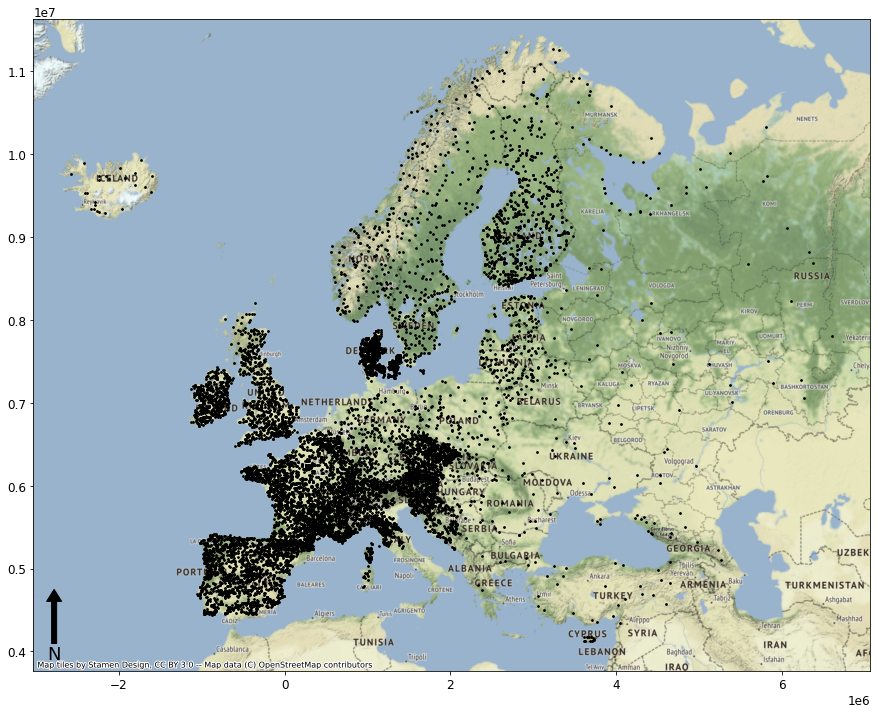

In [223]:
geospatialfunctions.plotpointsmap(network_EU.set_index("new_code").loc[:, ["lon", "lat"]], showcodes = False)

#### * Time-series read:

Here we read the time-series dataframes. It may take a while. 

In [169]:
# 1. Austria:
timeseries_AT = pd.read_csv(r"Austria\timeseries\timeseries_ATo.csv", index_col=0)
timeseries_AT.index = pd.to_datetime(timeseries_AT.index)
timeseries_AT.index.name = "dates"
timeseries_AT

,AT00001,AT00002,AT00003,AT00004,AT00005,AT00006,AT00007,AT00008,AT00009,AT00010,...,AT00590,AT00591,AT00592,AT00593,AT00594,AT00595,AT00596,AT00597,AT00598,AT00599
dates,,,,,,,,,,,,,,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
# 1. Austria:
timeseries_AT = pd.read_csv(r"Austria\timeseries\timeseries_ATo.csv", index_col=0)
timeseries_AT.index = pd.to_datetime(timeseries_AT.index)
timeseries_AT.index.name = "dates"

# 2. Belgium:
timeseries_BE = pd.read_csv(r"Julia\timeseries\timeseries_BEo.csv", index_col=0)
timeseries_BE.index = pd.to_datetime(timeseries_BE.index)
timeseries_BE.index.name = "dates"

# 3. Belarus:
timeseries_BY = pd.read_csv(r"GRDC\timeseries\countries\timeseries_BYo.csv", index_col=0)
timeseries_BY.index = pd.to_datetime(timeseries_BY.index)
timeseries_BY.index.name = "dates"

# 4. Bosnia and Herzegovina:
timeseries_BA = pd.read_csv(r"Bosnia\timeseries\timeseries_BAo.csv", index_col=0)
timeseries_BA.index = pd.to_datetime(timeseries_BA.index)
timeseries_BA.index.name = "dates"

# 5. Croatia:
timeseries_HR = pd.read_csv(r"Croatia\timeseries\timeseries_HRo.csv", index_col=0)
timeseries_HR.index = pd.to_datetime(timeseries_HR.index)
timeseries_HR.index.name = "dates"

# 6. Cyprus:
timeseries_CY = pd.read_csv(r"GRDC\timeseries\countries\timeseries_CYo.csv", index_col=0)
timeseries_CY.index = pd.to_datetime(timeseries_CY.index)
timeseries_CY.index.name = "dates"

# 7. Czechia:
timeseries_CZ = pd.read_csv(r"Julia\timeseries\timeseries_CZo.csv", index_col=0)
timeseries_CZ.index = pd.to_datetime(timeseries_CZ.index)
timeseries_CZ.index.name = "dates"

# 8. Denmark
timeseries_DK = pd.read_csv(r"Julia\timeseries\timeseries_DKo.csv", index_col=0)
timeseries_DK.index = pd.to_datetime(timeseries_DK.index)
timeseries_DK.index.name = "dates"

# 9. Estonia
timeseries_EE = pd.read_csv(r"GRDC\timeseries\countries\timeseries_EEo.csv", index_col=0)
timeseries_EE.index = pd.to_datetime(timeseries_EE.index)
timeseries_EE.index.name = "dates"

# 10. Finland
timeseries_FI = pd.read_csv(r"Julia\timeseries\timeseries_FIo.csv", index_col=0)
timeseries_FI.index = pd.to_datetime(timeseries_FI.index)
timeseries_FI.index.name = "dates"

# 11. France:
timeseries_FR = pd.read_csv(r"France\timeseries\timeseries_FRo.csv", index_col=0)
timeseries_FR.index = pd.to_datetime(timeseries_FR.index)
timeseries_FR.index.name = "dates"

# 12. Germany
timeseries_DE = pd.read_csv(r"GRDC\timeseries\countries\timeseries_DEo.csv", index_col=0)
timeseries_DE.index = pd.to_datetime(timeseries_DE.index)
timeseries_DE.index.name = "dates"

# 13. Greece ***
timeseries_GR = pd.read_csv(r"GRDC\timeseries\countries\timeseries_GRo.csv", index_col=0)
timeseries_GR.index = pd.to_datetime(timeseries_GR.index)
timeseries_GR.index.name = "dates"

# 14. Great Britain:
timeseries_GB = pd.read_csv(r"GB\timeseries\timeseries_GBo.csv", index_col=0)
timeseries_GB.index = pd.to_datetime(timeseries_GB.index)
timeseries_GB.index.name = "dates"

# 15. Hungary ***
timeseries_HU = pd.read_csv(r"GRDC\timeseries\countries\timeseries_HUo.csv", index_col=0)
timeseries_HU.index = pd.to_datetime(timeseries_HU.index)
timeseries_HU.index.name = "dates"

# 16. Iceland
timeseries_IS = pd.read_csv(r"GRDC\timeseries\countries\timeseries_ISo.csv", index_col=0)
timeseries_IS.index = pd.to_datetime(timeseries_IS.index)
timeseries_IS.index.name = "dates"

# 17. Ireland
timeseries_IE = pd.read_csv(r"Ireland\timeseries\timeseries_IEo.csv", index_col=0)
timeseries_IE.index = pd.to_datetime(timeseries_IE.index)
timeseries_IE.index.name = "dates"

# 18. Italy
timeseries_IT = pd.read_csv(r"IT\timeseries\timeseries_ITo.csv", index_col=0)
timeseries_IT.index = pd.to_datetime(timeseries_IT.index)
timeseries_IT.index.name = "dates"

# 19. Latvia:
timeseries_LV = pd.read_csv(r"GRDC\timeseries\countries\timeseries_LVo.csv", index_col=0)
timeseries_LV.index = pd.to_datetime(timeseries_LV.index)
timeseries_LV.index.name = "dates"

# 20. Lithuania:
timeseries_LT = pd.read_csv(r"GRDC\timeseries\countries\timeseries_LTo.csv", index_col=0)
timeseries_LT.index = pd.to_datetime(timeseries_LT.index)
timeseries_LT.index.name = "dates"

# 21. Luxembourg
timeseries_LU = pd.read_csv(r"Julia\timeseries\timeseries_LUo.csv", index_col=0)
timeseries_LU.index = pd.to_datetime(timeseries_LU.index)
timeseries_LU.index.name = "dates"

# 22. Netherlands
# Julia:
timeseries_NL = pd.read_csv(r"Julia\timeseries\timeseries_NLo.csv", index_col=0)
timeseries_NL.index = pd.to_datetime(timeseries_NL.index)
timeseries_NL.index.name = "dates"

# GRDC:
timeseries_NL_grdc = pd.read_csv(r"GRDC\timeseries\countries\timeseries_NL_grdc_o.csv", index_col=0)
timeseries_NL_grdc.index = pd.to_datetime(timeseries_NL_grdc.index)
timeseries_NL_grdc.index.name = "dates"

# 23. Northern Ireland
timeseries_NI = pd.read_csv(r"NorthernIreland\timeseries\timeseries_NIo.csv", index_col=0)
timeseries_NI.index = pd.to_datetime(timeseries_NI.index)
timeseries_NI.index.name = "dates"

# 24. Norway
timeseries_NO = pd.read_csv(r"Julia\timeseries\timeseries_NOo.csv", index_col=0)
timeseries_NO.index = pd.to_datetime(timeseries_NO.index)
timeseries_NO.index.name = "dates"

# 25. Poland:
timeseries_PL = pd.read_csv(r"GRDC\timeseries\countries\timeseries_PLo.csv", index_col=0)
timeseries_PL.index = pd.to_datetime(timeseries_PL.index)
timeseries_PL.index.name = "dates"

# 26. Portugal
timeseries_PT = pd.read_csv(r"Portugal\timeseries\timeseries_PTo.csv", index_col=0)
timeseries_PT.index = pd.to_datetime(timeseries_PT.index)
timeseries_PT.index.name = "dates"

# 27. Romania:
timeseries_RO = pd.read_csv(r"GRDC\timeseries\countries\timeseries_ROo.csv", index_col=0)
timeseries_RO.index = pd.to_datetime(timeseries_RO.index)
timeseries_RO.index.name = "dates"

# 28. Russia:
timeseries_RU = pd.read_csv(r"GRDC\timeseries\countries\timeseries_RUo.csv", index_col=0)
timeseries_RU.index = pd.to_datetime(timeseries_RU.index)
timeseries_RU.index.name = "dates"

# 29. Serbia
timeseries_RS = pd.read_csv(r"Serbia\timeseries\timeseries_RSo.csv", index_col=0)
timeseries_RS.index = pd.to_datetime(timeseries_RS.index)
timeseries_RS.index.name = "dates"

# 30. Slovakia
timeseries_SK = pd.read_csv(r"GRDC\timeseries\countries\timeseries_SKo.csv", index_col=0)
timeseries_SK.index = pd.to_datetime(timeseries_SK.index)
timeseries_SK.index.name = "dates"

# 31. Slovenia
timeseries_SI = pd.read_csv(r"Slovenia\timeseries\timeseries_SIo.csv", index_col=0)
timeseries_SI.index = pd.to_datetime(timeseries_SI.index)
timeseries_SI.index.name = "dates"

# 32. Spain
timeseries_ES = pd.read_csv(r"Spain\timeseries\timeseries_ESo.csv", index_col=0)
timeseries_ES.index = pd.to_datetime(timeseries_ES.index)
timeseries_ES.index.name = "dates"

# 33. Sweden
timeseries_SE = pd.read_csv(r"Julia\timeseries\timeseries_SEo.csv", index_col=0)
timeseries_SE.index = pd.to_datetime(timeseries_SE.index)
timeseries_SE.index.name = "dates"

# 34. Switzerland
timeseries_CH = pd.read_csv(r"Switzerland\timeseries\timeseries_CHo.csv", index_col=0)
timeseries_CH.index = pd.to_datetime(timeseries_CH.index)
timeseries_CH.index.name = "dates"

#______________________________________________________________________________________________________________________________

# 35. North Macedonia
timeseries_MK = pd.read_csv(r"GRDC\timeseries\countries\timeseries_MKo.csv", index_col=0)
timeseries_MK.index = pd.to_datetime(timeseries_MK.index)
timeseries_MK.index.name = "dates"

# 36. Moldova
timeseries_MD = pd.read_csv(r"GRDC\timeseries\countries\timeseries_MDo.csv", index_col=0)
timeseries_MD.index = pd.to_datetime(timeseries_MD.index)
timeseries_MD.index.name = "dates"

# 37. Ukraine
timeseries_UA = pd.read_csv(r"GRDC\timeseries\countries\timeseries_UAo.csv", index_col=0)
timeseries_UA.index = pd.to_datetime(timeseries_UA.index)
timeseries_UA.index.name = "dates"

# 38. Turkey
timeseries_TR = pd.read_csv(r"GRDC\timeseries\countries\timeseries_TRo.csv", index_col=0)
timeseries_TR.index = pd.to_datetime(timeseries_TR.index)
timeseries_TR.index.name = "dates"

# 39. Bulgaria
timeseries_BG = pd.read_csv(r"GRDC\timeseries\countries\timeseries_BGo.csv", index_col=0)
timeseries_BG.index = pd.to_datetime(timeseries_BG.index)
timeseries_BG.index.name = "dates"

#### * Time-series  concatenation:

It is important to first change the columns names to avoid any further problem with columns having the same name in our dataframe. 

It is also important to make sure that during the concatenation of the time-series, they follow the same order as the order used for the concatenation of the network.

In [173]:
dfs = [timeseries_AT.copy(), timeseries_BE.copy(), timeseries_BY.copy(), timeseries_BA.copy(), timeseries_HR.copy(), 
                             timeseries_CY.copy(), timeseries_CZ.copy(), timeseries_DK.copy(), timeseries_EE.copy(), 
                             timeseries_FI.copy(), timeseries_FR.copy(), timeseries_DE.copy(), 
                             timeseries_GR.copy(), timeseries_GB.copy(), timeseries_HU.copy(),
                             timeseries_IS.copy(), timeseries_IE.copy(), timeseries_IT.copy(), timeseries_LV.copy(), 
                             timeseries_LT.copy(), timeseries_LU.copy(), timeseries_NL.copy(), 
                             timeseries_NL_grdc.copy(), timeseries_NI.copy(), 
                             timeseries_NO.copy(), timeseries_PL.copy(), timeseries_PT.copy(), timeseries_RO.copy(), 
                             timeseries_RU.copy(), timeseries_RS.copy(), timeseries_SK.copy(), timeseries_SI.copy(), 
                             timeseries_ES.copy(), timeseries_SE.copy(), timeseries_CH.copy(), 
                             timeseries_MK.copy(), timeseries_MD.copy(), timeseries_UA.copy(), timeseries_TR.copy(), 
                             timeseries_BG.copy()]

In [176]:
timeseries_EU = pd.DataFrame(index = pd.date_range('01-01-1900','12-31-2022', freq='D'))

countries = network_EU['country'].unique()
i = 0
for df in tqdm.tqdm(dfs):
    
    # Here we concatenate it:
    timeseries_EU = pd.concat([timeseries_EU, df], axis=1)

    i = i + 1
    

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:42<00:00,  1.06s/it]


In [177]:
timeseries_EU

,AT00001,AT00002,AT00003,AT00004,AT00005,AT00006,AT00007,AT00008,AT00009,AT00010,...,TR00027,TR00028,BG00001,BG00002,BG00003,BG00004,BG00005,BG00006,BG00007,BG00008
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
# Check if any column name is NaN
if any(pd.isna(column) for column in timeseries_EU.columns):
    nan_column_names = [column for column in timeseries_EU.columns if pd.isna(column)]
    print("Columns with NaN names:", nan_column_names)
else:
    print("No columns with NaN names.")

No columns with NaN names.


Here we save our dataframes:

In [46]:
network_EU.to_excel(r'EU\network_EU.xlsx') 
#timeseries_EU.to_csv(r'EU\timeseries_EU.csv')